In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/houseprices-new/sample_submission.csv
/kaggle/input/houseprices-new/train.csv
/kaggle/input/houseprices-new/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Finding the path for required datasets
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/houseprices-new/sample_submission.csv
/kaggle/input/houseprices-new/train.csv
/kaggle/input/houseprices-new/test.csv


In [4]:
# Import data set 
data=pd.read_csv('/kaggle/input/houseprices-new/train.csv')
data_test=pd.read_csv('/kaggle/input/houseprices-new/test.csv')
data_submission=pd.read_csv('/kaggle/input/houseprices-new/sample_submission.csv')

In [5]:
data.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

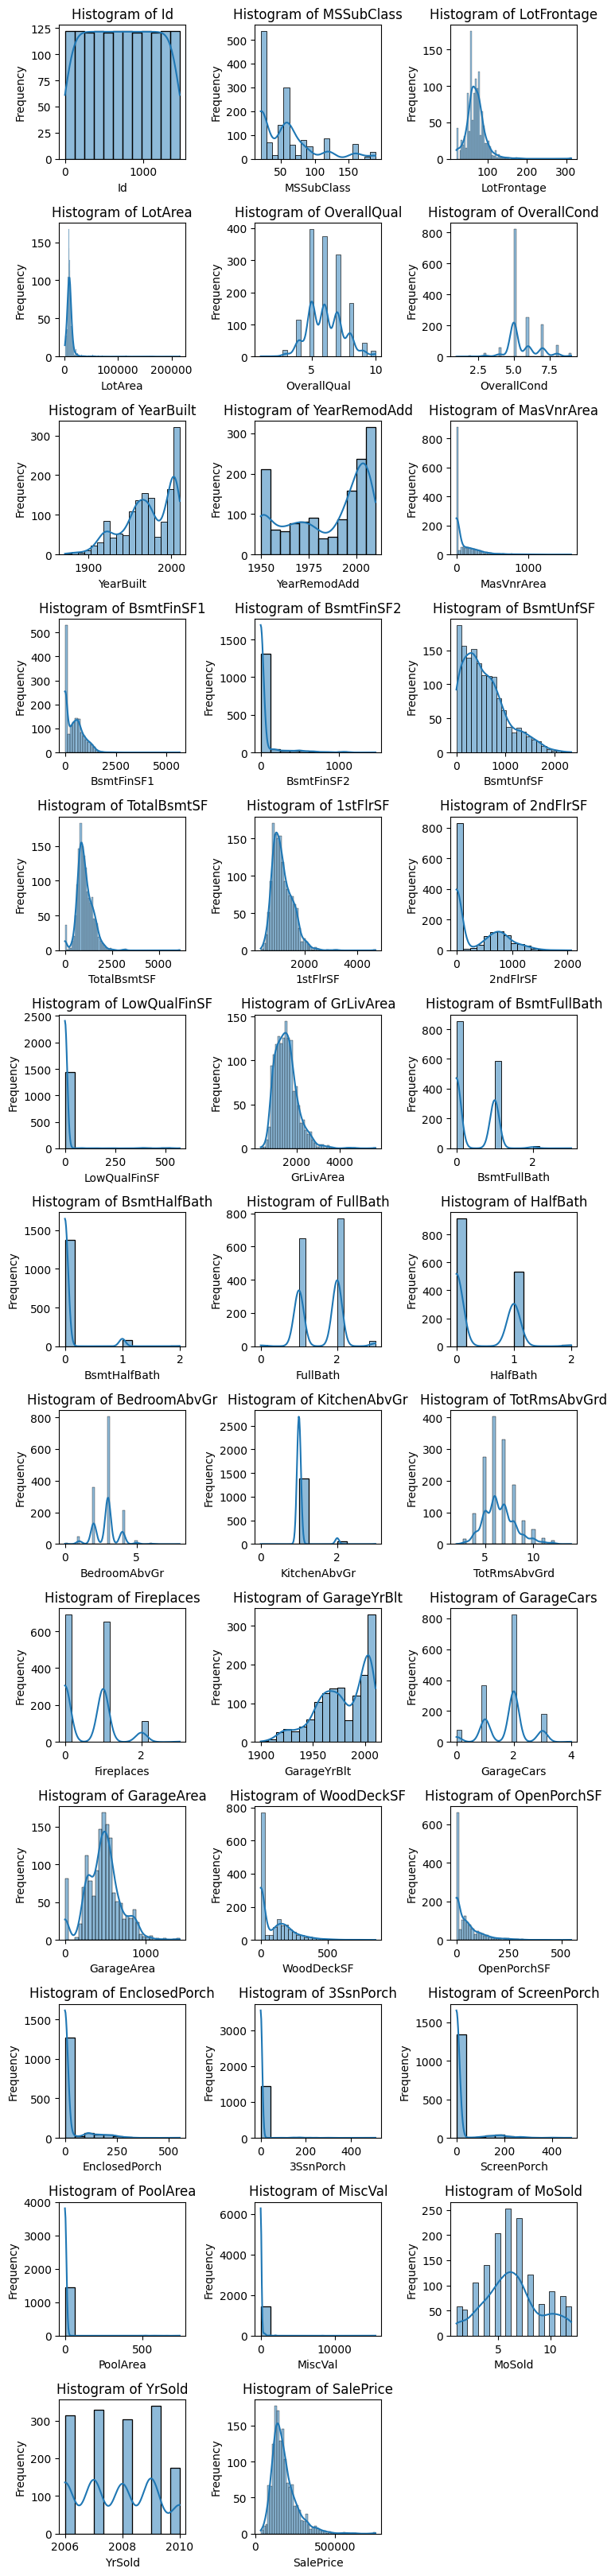

In [7]:
# Checking the distribution of all columns
# Define the number of columns per row
numerical_columns = data.select_dtypes(include=['number']).columns
cols = 3  
num_plots = len(numerical_columns)  # Total number of columns (features)
rows = (num_plots // cols) + (num_plots % cols > 0)  # Ensure enough rows

# Create subplots dynamically
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))
axes = axes.flatten()  # Flatten for easy iteration

# Example: Plot histograms for numerical features
for i, col in enumerate(numerical_columns):
    sns.histplot(data[col], kde=True, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide extra unused subplots
for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

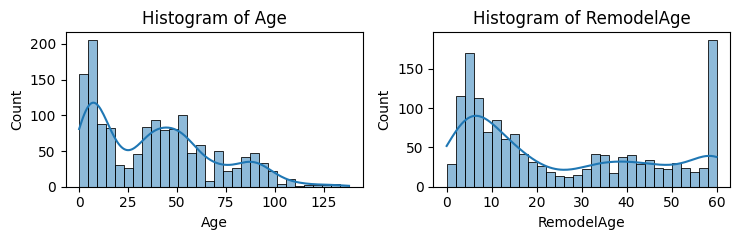

In [8]:
# Transform YearBuilt and YearRemodelAdd into Age and RemodelAge
current_year = data['YrSold'].max()  # Get the latest sale year

# Create new age-related features
data['Age'] = current_year - data['YearBuilt']
data['RemodelAge'] = current_year - data['YearRemodAdd']

# Plot the new Age & RemodelAge Feature
age_remodel=['Age','RemodelAge']
fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))  # 1 row, 2 columns

for i,col in enumerate(age_remodel):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [9]:
# Drop Year columns
data.drop(columns=['YearBuilt', 'YearRemodAdd'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 83 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [10]:
# Categorical Features with null values
# This Ensures that categorical values are not too diverse to be usefull for prediction
cat_obj_cols = data.select_dtypes(include=['category', 'object'])
null_features_cat = cat_obj_cols.columns[cat_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_cat,  # Feature names
    "Value Count": data[null_features_cat].count().values,  # Count of values
    "Missing Count": data[null_features_cat].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_cat].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,Alley,91,1369,2
1,MasVnrType,588,872,3
2,BsmtQual,1423,37,4
3,BsmtCond,1423,37,4
4,BsmtExposure,1422,38,4
5,BsmtFinType1,1423,37,6
6,BsmtFinType2,1422,38,6
7,Electrical,1459,1,5
8,FireplaceQu,770,690,5
9,GarageType,1379,81,6


Pool QC have 3 different type, with only 7 value
Misc Feature too anonymous with very low quantity of data to be meaningful

In [11]:
data.drop(columns=['PoolQC','MiscFeature'],inplace=True)

In [12]:
# Check further for Type of Alley Access and Fence Quality
print("Unique values in 'alley':", ', '.join(map(str, data['Alley'].unique())))
print("Unique values in 'fence':", ', '.join(map(str, data['Fence'].unique())))

Unique values in 'alley': nan, Grvl, Pave
Unique values in 'fence': nan, MnPrv, GdWo, GdPrv, MnWw


Fence : Fence Quality
GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
Ordinal relationship for fence

Alley: Type of alley access to property
       Grvl	Gravel
       Pave	Paved
       NA 	No alley access
Ordinal relationship for alley 
This is meaningful even with small data present, feature will be kept and Null Value will be set 0 (lowest order)

In [13]:
# Mapping for fence and alley
# Apply Fence mapping
data['Fence'] = data['Fence'].map({'MnWw': 1, 'MnPrv':2,'GdWo':3,'GdPrv':4})
data['Fence'].fillna(0, inplace=True)
data['Alley'] = data['Alley'].map({'Grvl':1,'Pave':2})
data['Alley'].fillna(0, inplace=True)
print(data['Fence'].unique())
print(data['Alley'].unique())

[0. 2. 3. 4. 1.]
[0. 1. 2.]


In [14]:
#Check for these categorical , wether to OHE or Ordinal According to Price
#1	MasVnrType	
#NA , CBlock, BrkCmn, BrkFace , Stone > Ord
data['MasVnrType'] =data['MasVnrType'].map({'CBlock':1,'BrkCmn':2,'BrkFace':3,'Stone':4})
#4	BsmtExposure	
#NA,No, Mn, Av, Gd > Ord
data['BsmtExposure']=data['BsmtExposure'].map({'No':1,'Mn':2,'Av':3,'Gd':4})
#7	Electrical << There is missing count 1 for this value, will be filled with mode
#FuseP, FuseF, FuseA, Mix, SBrkr > Ord
data['Electrical']=data['Electrical'].map({'FuseP':1,'FuseF':2,'FuseA':3,'Mix':4,'SBrkr':4})
#9	GarageType 
#NA, CarPort, Detchd, Basment, Attchd, BuiltIn, 2Types > Ord
data['GarageType']=data['GarageType'].map({'CarPort':1,'Detchd':2,'Basment':3,'Attchd':4,'BuiltIn':5,'2Types':6})
#10	GarageFinish	
#NA, Unf, RFn, Fin > Ord
data['GarageFinish']=data['GarageFinish'].map({'Unf':1,'RFn':2,'Fin':3})
#5	BsmtFinType1	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
data['BsmtFinType1']=data['BsmtFinType1'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#6	BsmtFinType2	
#NA, Unf, LwQ, Rec, BLQ, ALQ, GLQ > Ord
data['BsmtFinType2']=data['BsmtFinType2'].map({'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
#2	BsmtQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#3	BsmtCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#11	GarageQual	
#NA, Po, Fa, TA, Gd, Ex > Ord
#12	GarageCond	
#NA, Po, Fa, TA, Gd, Ex > Ord
#8	FireplaceQu	
#NA, Po, Fa, TA, Gd, Ex > Ord
same_col5=['BsmtQual','BsmtCond','GarageQual','GarageCond','FireplaceQu']
for col in same_col5:
    data[col]=data[col].map({'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})

# Show only columns with missing values
missing_features = data.isnull().sum()
missing_features = missing_features[missing_features > 0]  # Keep only features with missing values

# Display the features and their missing count
print(missing_features)

LotFrontage     259
MasVnrType      872
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64


In [15]:
# Fill NA with 0 for all of the categorical columns above Except Electrical
remove_items = ['Alley','Electrical','PoolQC','Fence','MiscFeature']
same_null11 = [col for col in null_features_cat if col not in remove_items]
for col in same_null11:
    data[col].fillna(0, inplace=True)
    print(data[col].unique())
# Fill Electrical with mode
data['Electrical'].fillna(data['Electrical'].mode()[0], inplace=True)
print(data['Electrical'].unique())

[3. 0. 4. 2.]
[4. 3. 5. 0. 2.]
[3. 4. 0. 2. 1.]
[1. 4. 2. 3. 0.]
[6. 5. 1. 3. 4. 0. 2.]
[1. 4. 0. 5. 3. 2. 6.]
[0. 3. 4. 2. 5. 1.]
[4. 2. 5. 1. 0. 3. 6.]
[2. 1. 3. 0.]
[3. 2. 4. 0. 5. 1.]
[3. 2. 0. 4. 1. 5.]
[4. 2. 3. 1.]


In [16]:
# Handling Null values for numerical columns
num_obj_cols = data.select_dtypes(include=['int64', 'float64'])
null_features_num = num_obj_cols.columns[num_obj_cols.isnull().any()].tolist()

# Convert to DataFrame for better display
pd.DataFrame({
    "Feature": null_features_num,  # Feature names
    "Value Count": data[null_features_num].count().values,  # Count of values
    "Missing Count": data[null_features_num].isnull().sum().values,  # Count of values
    "Unique Count": data[null_features_num].nunique().values  # Count of unique values
})

,Feature,Value Count,Missing Count,Unique Count
0,LotFrontage,1201,259,110
1,MasVnrArea,1452,8,327
2,GarageYrBlt,1379,81,97


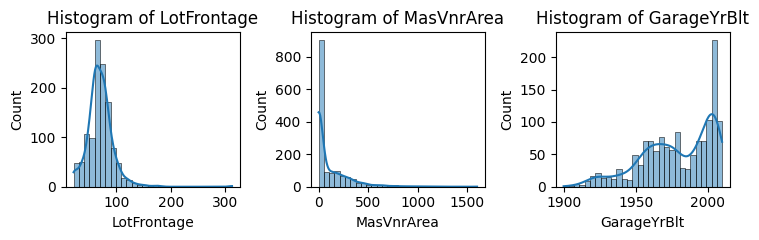

In [17]:
# Lets plot the distribution for these missing values
missing_numerical=['LotFrontage','MasVnrArea','GarageYrBlt']
fig, axes = plt.subplots(1, 3, figsize=(7.5, 2.5))  # 1 row, 3 columns
for i,col in enumerate(missing_numerical):
    sns.histplot(data=data, x=col, bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')

plt.tight_layout()
plt.show()

In [18]:
# LotFrontage is approximately normal, MasVnrArea and GarageYrBlt are skewed
# fillna with respective values
data['LotFrontage'].fillna(data['LotFrontage'].mean(), inplace=True)
data['MasVnrArea'].fillna(data['MasVnrArea'].median(), inplace=True)
data['GarageYrBlt'].fillna(data['GarageYrBlt'].median(), inplace=True)

# There will be no more null values
data.isnull().values.any()

False

In [19]:
# Check further for Type of LandContour HouseStyle Exterior2nd SaleCondition since the 
# value in web is incorrect
check_uniqueLHES=['LandContour','HouseStyle','Exterior2nd','SaleCondition']
for i in check_uniqueLHES:
    print(f"Unique values in {i} :", ', '.join(map(str, data[i].unique())))

Unique values in LandContour : Lvl, Bnk, Low, HLS
Unique values in HouseStyle : 2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl, 2.5Unf, 2.5Fin
Unique values in Exterior2nd : VinylSd, MetalSd, Wd Shng, HdBoard, Plywood, Wd Sdng, CmentBd, BrkFace, Stucco, AsbShng, Brk Cmn, ImStucc, AsphShn, Stone, Other, CBlock
Unique values in SaleCondition : Normal, Abnorml, Partial, AdjLand, Alloca, Family


In [20]:
# Get the rest of categorical features
categorical_features = data.select_dtypes(include=['object', 'category']).columns
categorical_features

# Identifying ordinal / nominal categorical features & Map Ordinal Features
#'Street', Ordinal
# Pave, Grvl      
data['Street']=data['Street'].map({'Pave':0,'Grvl':1})
#'LandContour', custom ordinal
#Low, HLS 0.9, Bnk 1.1, Lv1
data['LandContour']=data['LandContour'].map({'Low':0,'HLS':0.9,'Bnk':1.1,'Lvl':2})
#'Utilities', ordinal
#ELO, NoSeWa, NoSewr, AllPub
data['Utilities']=data['Utilities'].map({'ELO':0,'NoSeWa':1,'NoSewr':2,'AllPub':3})
#'LandSlope', ordinal
# Sev, Mod, Gtl
data['LandSlope']=data['LandSlope'].map({'Sev':0,'Mod':1,'Gtl':2})
#'HouseStyle', 
# 1Story, 1.5Unf, 1.5Fin , SLvl 2.2, SFoyer 2.2, 2Story, 2.5Unf, 2.5Fin
data['HouseStyle']=data['HouseStyle'].map({'1Story':0,'1.5Unf':1,'1.5Fin':2,'SLvl':2.2,'SFoyer':2.2,'2Story':3,'2.5Unf':4,'2.5Fin':5})
#'RoofStyle', 
#Flat , Shed, Gable, Gambrel, Hip, Mansard
data['RoofStyle']=data['RoofStyle'].map({'Flat':0,'Shed':1,'Gable':2,'Gambrel':3,'Hip':4,'Mansard':5})
#'RoofMatl', 
#Roll, Tar&Grv, Membran, CompShg, WdShngl, WdShake, Metal, ClyTile
data['RoofMatl']=data['RoofMatl'].map({'Roll':0,'Tar&Grv':1,'Membran':2,'CompShg':3,'WdShngl':4,'WdShake':5,'Metal':6,'ClyTile':7})
#'Exterior1st',
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, WdShing, CemntBd, BrkComm, BrkFace, Stone
data['Exterior1st']=data['Exterior1st'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'WdShing':12,'CemntBd':13,'BrkComm':14,'BrkFace':15,'Stone':16})
#'Exterior2nd', 
#CBlock, Plywood, Other, AsbShng, HdBoard, PreCast, ImStucc, MetalSd, VinylSd, 
#AsphShn, Stucco, Wd Sdng, Wd Shng, CmentBd, Brk Cmn, BrkFace, Stone
data['Exterior2nd']=data['Exterior2nd'].map({'CBlock':0,'Plywood':1,'Other':2,'AsbShng':3,'HdBoard':4,'PreCast':5,'ImStucc':6,'MetalSd':7,'VinylSd':8,
                                      'AsphShn':9,'Stucco':10,'Wd Sdng':11,'Wd Shng':12,'CmentBd':13,'Brk Cmn':14,'BrkFace':15,'Stone':16})
#'Foundation', 
#Slab, CBlock, Wood, PConc, BrkTil, Stone
data['Foundation']=data['Foundation'].map({'Slab':0,'CBlock':1,'Wood':2,'PConc':3,'BrkTil':4,'Stone':5})
#'Heating',
#Grav, Wall, Floor, OthW, GasW, GasA
data['Heating']=data['Heating'].map({'Grav':0,'Wall':1,'Floor':2,'OthW':3,'GasW':4,'GasA':5})
#'CentralAir', 
#N, Y
data['CentralAir']=data['CentralAir'].map({'N':0,'Y':1})
#'Functional', 
#Sal, Sev, Maj2, Maj1, Mod, Min2, Min1, Typ
data['Functional']=data['Functional'].map({'Sal':0,'Sev':1,'Maj2':2,'Maj1':3,'Mod':4,'Min2':5,'Min1':6,'Typ':7})
#'PavedDrive',
#N,P,Y
data['PavedDrive']=data['PavedDrive'].map({'N':0,'P':1,'Y':2})
#'SaleType', 
#COD, Oth, ConLD, ConLI, ConLw, Con, VWD, CWD, WD, New
data['SaleType']=data['SaleType'].map({'COD':0,'Oth':1,'ConLD':2,'ConLI':3,'ConLw':4,'Con':5,'VWD':6,'CWD':7,'WD':8,'New':9})
#'SaleCondition'
#Abnorml, Family, AdjLand, Alloca, Partial, Normal
data['SaleCondition']=data['SaleCondition'].map({'Abnorml':0,'Family':1,'AdjLand':2,'Alloca':3,'Partial':4,'Normal':5})
#'HeatingQC', 
#Po, Fa, TA, Gd, Ex
#'KitchenQual', 
#Po, Fa, TA, Gd, Ex
#'ExterQual', 
#Po, Fa, TA, Gd, Ex
#'ExterCond', 
#Po, Fa, TA, Gd, Ex
same_col4=['HeatingQC','KitchenQual','ExterQual','ExterCond']
for col in same_col4:
    data[col]=data[col].map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
#'MSZoning', Nominal
#'LotShape', nominal
#'LotConfig', nominal
#'Neighborhood', nominal
#'Condition1', nominal
#'Condition2', nom
#'BldgType', nom
nominal_category=['MSZoning','LotShape','LotConfig','Neighborhood','Condition1','Condition2','BldgType']
data = pd.get_dummies(data, columns=nominal_category, drop_first=True)
data.shape

(1460, 128)

In [21]:
# There is mis information in website that need changes ( wrong feature unique values )
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

In [22]:
# Checking correlation before transforming features
# Correlation only with SalePrice
correlation_with_saleprice = data.corr()["SalePrice"].sort_values(ascending=False)
pd.set_option("display.max_rows", None)
print(correlation_with_saleprice)

SalePrice               1.000000
OverallQual             0.790982
GrLivArea               0.708624
ExterQual               0.682639
KitchenQual             0.659600
GarageCars              0.640409
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
BsmtQual                0.585207
FullBath                0.560664
GarageFinish            0.549247
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
FireplaceQu             0.520438
YearRemodAdd            0.507101
GarageType              0.478885
MasVnrArea              0.472614
Fireplaces              0.466929
GarageYrBlt             0.466754
HeatingQC               0.427649
Neighborhood_NridgHt    0.402149
MasVnrType              0.401151
BsmtFinSF1              0.386420
BsmtExposure            0.374696
LotFrontage             0.334901
Neighborhood_NoRidge    0.330424
WoodDeckSF              0.324413
2ndFlrSF                0.319334
OpenPorchSF             0.315856
BsmtFinTyp

In [23]:
# MODEL BUILDING
from sklearn.model_selection import train_test_split

# 🔹 Define Features (X) and Target (y)
x = data.drop(columns=['SalePrice'])  # Replace 'SalePrice' with your target column
y = data['SalePrice']

# 🔹 Split into Train and Test Sets (80% Train, 20% Test)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

# 🔹 Print Shapes to Confirm
print(f"x_train Shape: {x_train.shape}, x_test Shape: {x_test.shape}")
print(f"y_train Shape: {y_train.shape}, y_test Shape: {y_test.shape}")

x_train Shape: (1168, 127), x_test Shape: (292, 127)
y_train Shape: (1168,), y_test Shape: (292,)


In [24]:
# Check missing values
missing_features = x_test.isnull().sum()
missing_features = missing_features[missing_features > 0]  # Keep only features with missing values

# Display the features and their missing count
print(missing_features)


Series([], dtype: int64)


In [25]:
# Regression metrics function
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold

def adj_r2(predictors, target, predictions):
    r2 = r2_score(target,predictions)
    n=predictors.shape[0]
    k=predictors.shape[1]
    return 1-((1-r2)*(n-1)/(n-k-1))

def mape_score(targets,predictions):
    return np.mean(np.abs(targets-predictions)/targets)* 100

# Cross validated performance metric
def model_performance_regression(model, predictors, target):
    pred = model.predict(predictors)
    
    r2 = r2_score(target, pred)
    adjr2 = adj_r2(predictors, target, pred)
    rmse = np.sqrt(mean_squared_error(target, pred))
    mae = mean_absolute_error(target, pred)
    mape = mape_score(target, pred)
        
    df_perf=pd.DataFrame ({
        "R2":r2,
        "Adj-R2":adjr2,
        "RMSE":rmse,
        "MAE":mae,
        "MAPE":mape
    }, index=[0]
                         )
    return df_perf

In [26]:
# Linear regression model for benchmark before feature engineering

# Train Linear Regression Model
modelLR_benchmark = LinearRegression()
modelLR_benchmark.fit(x_train, y_train)

LinearRegression()

In [27]:
# model performance check
model_performance_regression(modelLR_benchmark, x_test, y_test)

,R2,Adj-R2,RMSE,MAE,MAPE
0,0.84593,0.72662,33148.431658,20629.522739,12.68242


MODEL BENCHMARK
_________________________________________________________________________________
CUSTOM MODEL BUILDING

In [28]:
# Do OLS to get better statistical summary